## Analysis with "DumbTo" Stimulus

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import numpy.ma as ma

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.preprocessing import label_binarize

from itertools import cycle

from imblearn.over_sampling import SMOTE

 import pickle

In [2]:
sub_DumbTo = pd.read_csv("./Data/Subsamples/DumbTo.csv")

# For RPD and SPD we can use the raw or normed versions, which one?
related_features = ['Subject_ID',
       'FPOGX', 'FPOGY', 
       'BPOGX', 'BPOGY', 
       'LPCX', 'LPCY', 'Normed_LPD', 'Normed_LPS', 'RPCX', 'RPCY', 'Normed_RPD', 'Normed_RPS', 
       'LPUPILD', 'RPUPILD', 
       'Anger_Evidence', 'Contempt_Evidence', 'Disgust_Evidence', 'Joy_Evidence', 'Fear_Evidence',
       'Negative_Evidence', 'Neutral_Evidence', 'Positive_Evidence', 'Sadness_Evidence', 'Surprise_Evidence', 
       'Normed_Heart_Rate']

data_recall = pd.read_csv('./Data/Lab_Recall_Hand_Edited/SuperMovie1516_L.csv')

idx_to_col_name = {k: v for k, v in enumerate(related_features[1:])}

In [3]:
seq_length = sub_DumbTo.groupby("Subject_ID").size().reset_index()
seq_length.columns = ["Subject_ID", "Length"]
num_of_subjects = seq_length.shape[0]
print("Number of subjects:", num_of_subjects)

print("Min sequence lengh: ",seq_length.Length.min())

Number of subjects: 45
Min sequence lengh:  9676


In [4]:
# remove user 344 from seq-length and data (length is outlier)
seq_length = seq_length[seq_length.Subject_ID != 344]
sub_DumbTo = sub_DumbTo[sub_DumbTo.Subject_ID != 344]

In [5]:
num_of_subjects = seq_length.shape[0]
print("Number of subjects:", num_of_subjects)

Number of subjects: 44


In [6]:
cut_off = seq_length.Length.min()
print("Cutoff is :", cut_off)

Cutoff is : 9744


In [7]:
seq_length['Sum_Length'] = seq_length.Length.cumsum() 
seq_length = seq_length.reset_index()

# Adjust the length of all seqs
#cut_off = seq_length.Length.min()
cut_off = 9741

rem_index = np.zeros(sub_DumbTo.shape[0])
rem_index[0 : cut_off] = 1  
for i in range(0, seq_length.shape[0]-1):
    rem_index[seq_length.Sum_Length[i] : seq_length.Sum_Length[i]  + cut_off] = 1
    
sub_DumbTo["Rem_Index"] = rem_index

sub_DumbTo = sub_DumbTo[sub_DumbTo.Rem_Index == 1]

print("Sqeuence length after adjustment:", sub_DumbTo.shape[0]/44)

sub_DumbTo = sub_DumbTo[related_features]

Sqeuence length after adjustment: 9741.0


In [8]:
num_non_zero_nulls_in_cols = sub_DumbTo.isnull().sum().reset_index()
num_non_zero_nulls_in_cols.columns = ["Column", "Num_Nulls"]
num_non_zero_nulls_in_cols = num_non_zero_nulls_in_cols[num_non_zero_nulls_in_cols.Num_Nulls != 0]

In [9]:
# In the data one user has no value for the above columns and the first value of all users is null
num_non_zero_nulls_in_cols

,Column,Num_Nulls
8,Normed_LPS,9784
12,Normed_RPS,9784


In [10]:
# remove user 345 from seq-length and data (has missing values for 4 columns)
seq_length = seq_length[seq_length.Subject_ID != 345]
sub_DumbTo = sub_DumbTo[~sub_DumbTo.Normed_LPS.isna()]
# We can remove all nulls and make the sequnce one unit smaller
sub_DumbTo = sub_DumbTo.dropna()

# For the above four columns the first element of each sequence was na, so the sequence length (cut_off) is reduced by 1
cut_off = cut_off - 1
num_of_subjects = int(sub_DumbTo.shape[0]/(cut_off))
print("Sequence length (cutt_off) equls: ", cut_off)
print("Number of Subjects is: ", num_of_subjects)

sub_DumbTo = sub_DumbTo.reset_index()
sub_DumbTo = sub_DumbTo.drop(columns = ["index"])

Sequence length (cutt_off) equls:  9740
Number of Subjects is:  43


In [11]:
y = [data_recall[data_recall.ExternalReference == i].DumbTo.tolist()[0] for i in seq_length.Subject_ID]
y = [1 if i>5 else 0 for i in y]
y = np.array(y)

id_to_y = {}
for i in seq_length.Subject_ID:
    if data_recall[data_recall.ExternalReference == i].DumbTo.tolist()[0] > 5:
        id_to_y[i] = 1
    else:
        id_to_y[i] = 0
#id_to_y = {i: data_recall[data_recall.ExternalReference == i].DumbTo.tolist()[0] for i in seq_length.Subject_ID}


print('len(y):', len(y))

len(y): 43


In [12]:
sum(y==1)

37

In [13]:
sub_DumbTo = sub_DumbTo.reset_index()
sub_DumbTo["index"] = sub_DumbTo["index"] + 1

In [14]:
sub_DumbTo

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,1,300,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,2,300,0.68125,0.42685,0.68750,0.49259,0.25011,0.41384,-0.821955,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,3,300,0.68125,0.43241,0.68594,0.50556,0.25011,0.41384,-0.821955,1.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,4,300,0.87396,0.43611,2.58698,0.46574,0.24719,0.40959,-12.431953,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,5,300,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418815,418816,365,0.37031,0.39815,0.39792,0.38333,0.26668,0.72261,-2.647524,0.0,...,-0.407128,-0.156432,-1.473553,-1.841570,2.932494,-1.194771,-0.932807,-1.932029,-1.989926,-40.433041
418816,418817,365,0.37187,0.39907,0.39323,0.40648,0.26660,0.72223,-2.797525,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418817,418818,365,0.37240,0.40093,0.37865,0.42963,0.26636,0.72297,-3.027524,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418818,418819,365,0.37396,0.39815,0.39010,0.36019,0.26663,0.72167,-3.217525,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041


In [15]:
x_raw = np.array(sub_DumbTo.iloc[:,2:])
x_raw = x_raw.reshape(num_of_subjects, cut_off, -1)

In [16]:
x_raw.shape

(43, 9740, 25)

In [36]:
42 - 6

36

In [39]:
sub_DumbTo = sub_DumbTo.drop(columns=["index"])

In [81]:

for i, y_i in enumerate(y):
    mask = np.repeat(True, len(y))
    mask[i] = False
    
    y_train = y[mask]   
    x_train = x_raw[mask]
    
    y_valid = y[i]
    x_valid = x_raw[i]
    
    x_for_smote = np.zeros((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
    for i, seq_feat_mat in enumerate(x_train):
        x_for_smote[i] = np.reshape(seq_feat_mat, x_train.shape[1] * x_train.shape[2])
        
    strategy = {0:12, 1:36} if y_i==1 else {0:11, 1:37}
    oversample = SMOTE(sampling_strategy=strategy, random_state=0, k_neighbors=3)
    x_res, y_res = oversample.fit_resample(x_for_smote, y_train)
    
    x_res_added = x_res[42:,]
#     y_res_added = y_res[42:,]

    x_valid_df = sub_DumbTo.iloc[i : i+cut_off].reset_index()
    x_valid_df = x_valid_df.drop(columns=["index"])
    x_train_df = sub_DumbTo.drop(sub_DumbTo.index[i : i+cut_off], axis=0).reset_index()
    x_train_df = x_train_df.drop(columns=["index"])
    
    x_added_df = pd.DataFrame(columns=related_features)
    id_x_added = {}
    for i, item in enumerate(x_res_added):
        item = np.reshape(item, (cut_off, -1))
        r_id = np.full((cut_off, 1), int(1000 + i))
        item =  np.hstack((r_id,item))
        item_df = pd.DataFrame(data=item, columns=related_features)
        x_added_df = x_added_df.append(item_df)
    
#     y_added_to_id = {int(i): y_res_added[int(1000 - i)] for i in x_added_df.Subject_ID.tolist()}
    
#     subject_id_unique = sub_DumbTo.Subject_ID.unique().tolist()
#     y_train_to_id = {}
#     y_valid_to_id = {}
#     for j, subject_id in subject_id_unique:
#         if j == i:
#             y_valid_to_id[subject_id] = y_i
#         else:
#             y_train_to_id[subject_id] = 
#     y_train_to_id = {k: id_to_y[k] for k in subject_id_unique[:42]}
#     y_train_to_id.update(y_added_to_id)
#     y_valid_to_id = {k: id_to_y[k] for k in subject_id_unique[37:]}

    x_train_df_tot = x_train_df.append(x_added_df)
    x_train_df_tot = x_train_df_tot.reset_index().drop(columns=["index"]).reset_index()
    
    unique_training_subject_ids = x_train_df_tot.Subject_ID.unique()
    unique_training_subject_ids = np.delete(unique_training_subject_ids, i)
    
    id_to_y_train = {_id: y_res[i] for _id, i in enumerate(unique_training_subject_ids)}
    
    group_1 = x_train_df_tot[x_train_df_tot.index % 4 == 0]
    group_2 = x_train_df_tot[x_train_df_tot.index % 4 == 1]
    group_3 = x_train_df_tot[x_train_df_tot.index % 4 == 2]
    group_4 = x_train_df_tot[x_train_df_tot.index % 4 == 3]
    
    data_train = group_1.append(group_2).append(group_3).append(group_4)
    
    x_train_augmented = data_train.to_numpy()
    
    num_train_subj = 42
    num_augmented_train_subj = num_train_subj + len(y_res_added)
    
    x_train_augmented_reshaped = x_train_augmented.reshape(int(num_augmented_train_subj) * 4, -1, len(related_features) + 1)
    
    np.random.seed(42)
    rng = np.random.default_rng()
    np.random.shuffle(x_train_augmented_reshaped)
    
    final_x_train = np.zeros((x_train_augmented_reshaped.shape[0], x_train_augmented_reshaped.shape[1],x_train_augmented_reshaped.shape[2]-2))
    final_y_train = np.zeros(x_train_augmented_reshaped.shape[0])
    
    for i, item in enumerate(x_train_augmented_reshaped):
        final_y_train[i] = id_to_y_train[int(item[0][1])]
        final_x_train[i] = np.delete(item,np.s_[0:2],axis=1)
    
    
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [273]:
final_results = []
training_acc = []
for i, y_i in enumerate(y):
    mask = np.repeat(True, len(y))
    mask[i] = False

    y_train = y[mask]   
    x_train = x_raw[mask]

    y_valid = y[i]
    x_valid = x_raw[i]

    x_for_smote = np.zeros((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
    for j, seq_feat_mat in enumerate(x_train):
        x_for_smote[j] = np.reshape(seq_feat_mat, x_train.shape[1] * x_train.shape[2])

    strategy = {0:12, 1:36} if y_i==1 else {0:11, 1:37}
    oversample = SMOTE(sampling_strategy=strategy, random_state=0, k_neighbors=3)
    x_res, y_res = oversample.fit_resample(x_for_smote, y_train)

    x_res_added = x_res[42:,]
    y_res_added = y_res[42:,]

    x_valid_df = sub_DumbTo.iloc[i*cut_off : (i+1)*cut_off].reset_index()
    x_valid_df = x_valid_df.drop(columns=["index"])
    x_train_df = sub_DumbTo.drop(sub_DumbTo.index[i*cut_off : (i+1)*cut_off], axis=0).reset_index()
    x_train_df = x_train_df.drop(columns=["index"])

    x_added_df = pd.DataFrame(columns=related_features)
    id_x_added = {}

    for k, item in enumerate(x_res_added):
        item = np.reshape(item, (cut_off, -1))
        r_id = np.full((cut_off, 1), int(1000 + k))
        item =  np.hstack((r_id,item))
        item_df = pd.DataFrame(data=item, columns=related_features)
        x_added_df = x_added_df.append(item_df)

    x_train_df_tot = x_train_df.append(x_added_df)
    x_train_df_tot = x_train_df_tot.reset_index().drop(columns=["index"]).reset_index()

    unique_training_subject_ids = x_train_df_tot.Subject_ID.unique()
    #unique_training_subject_ids = np.delete(unique_training_subject_ids, i)

    id_to_y_train = {_id: y_res[i] for i, _id in enumerate(unique_training_subject_ids)}

    group_1 = x_train_df_tot[x_train_df_tot.index % 4 == 0]
    group_2 = x_train_df_tot[x_train_df_tot.index % 4 == 1]
    group_3 = x_train_df_tot[x_train_df_tot.index % 4 == 2]
    group_4 = x_train_df_tot[x_train_df_tot.index % 4 == 3]

    data_train = group_1.append(group_2).append(group_3).append(group_4)

    x_train_augmented = data_train.to_numpy()

    num_train_subj = 42
    num_augmented_train_subj = num_train_subj + len(y_res_added)

    x_train_augmented_reshaped = x_train_augmented.reshape(int(num_augmented_train_subj) * 4, -1, len(related_features) + 1)

    np.random.seed(42)
    rng = np.random.default_rng()
    np.random.shuffle(x_train_augmented_reshaped)

    final_x_train = np.zeros((x_train_augmented_reshaped.shape[0], x_train_augmented_reshaped.shape[1],x_train_augmented_reshaped.shape[2]-2))
    final_y_train = np.zeros(x_train_augmented_reshaped.shape[0])

    for l, item in enumerate(x_train_augmented_reshaped):
        final_y_train[l] = id_to_y_train[int(item[0][1])]
        final_x_train[l] = np.delete(item,np.s_[0:2],axis=1)
        
    special_value = -9999.99
    model = keras.Sequential()
    model.add(keras.layers.Masking(mask_value=special_value, input_shape=(final_x_train.shape[1], final_x_train.shape[2])))
    model.add(keras.layers.LSTM(256, kernel_regularizer=keras.regularizers.l2(l=0.05)))
    model.add(keras.layers.Dense(2, kernel_regularizer=keras.regularizers.l2(l=0.05), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    
    weights = {0:4, 1:1}
    history = model.fit(x = final_x_train, y = final_y_train, class_weight=weights, epochs = 4)
    
    training_acc.append(history.history['accuracy'])
    
    model.save("./Saved_Models/lstm_loov_" + str(i))
    
    group_1 = x_valid_df[x_valid_df.index % 4 == 0]
    group_2 = x_valid_df[x_valid_df.index % 4 == 1]
    group_3 = x_valid_df[x_valid_df.index % 4 == 2]
    group_4 = x_valid_df[x_valid_df.index % 4 == 3]
    
    data_valid = group_1.append(group_2).append(group_3).append(group_4)
    
    x_valid_mat = np.array(data_valid)
    x_valid_reshaped = x_valid_mat.reshape(4, -1, len(related_features))
    
    final_x_valid = np.zeros((x_valid_reshaped.shape[0], x_valid_reshaped.shape[1],x_valid_reshaped.shape[2]-1))
    for m, item in enumerate(x_valid_reshaped):
        final_x_valid[m] = np.delete(item,np.s_[0:1],axis=1)
        
    y_pred = model.predict(final_x_valid)
    final_results.append(y_pred)
    
with open("loov_v7_results.txt", "wb") as fp:   #Pickling
    pickle.dump(final_results, fp)
    
with open("loov_v7_training_acc.txt", "wb") as fp:   #Pickling
    pickle.dump(training_acc, fp)

Epoch 1/4
6/6 [==============================] - 131s 22s/step - loss: 2.7312 - accuracy: 0.7031
Epoch 2/4
6/6 [==============================] - 132s 22s/step - loss: 1.0555 - accuracy: 0.9844
Epoch 3/4
6/6 [==============================] - 130s 22s/step - loss: 0.9989 - accuracy: 0.9167
Epoch 4/4
6/6 [==============================] - 131s 22s/step - loss: 0.7832 - accuracy: 0.9896
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_0\assets
Epoch 1/4
6/6 [==============================] - 127s 21s/step - loss: 3.3201 - accuracy: 0.6406
Epoch 2/4
6/6 [==============================] - 129s 22s/step - loss: 1.3730 - accuracy: 0.9219
Epoch 3/4
6/6 [==============================] - 129s 21s/step - loss: 1.1176 - accuracy: 0.9740
Epoch 4/4
6/6 [==============================] - 128s 21s/step - loss: 0.7503 - accuracy: 0.9635
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_1\assets
Epoch 1/4
6/6 [==============================] - 135s 22s/step - loss: 3.3679 - accura

Epoch 1/4
6/6 [==============================] - 153s 25s/step - loss: 2.8685 - accuracy: 0.7292
Epoch 2/4
6/6 [==============================] - 152s 25s/step - loss: 1.6794 - accuracy: 0.8229
Epoch 3/4
6/6 [==============================] - 152s 25s/step - loss: 1.2406 - accuracy: 0.9219
Epoch 4/4
6/6 [==============================] - 151s 25s/step - loss: 0.8448 - accuracy: 0.9844
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_8\assets
Epoch 1/4
6/6 [==============================] - 153s 25s/step - loss: 2.2851 - accuracy: 0.8438
Epoch 2/4
6/6 [==============================] - 153s 26s/step - loss: 0.8448 - accuracy: 0.9896
Epoch 3/4
6/6 [==============================] - 153s 26s/step - loss: 0.6632 - accuracy: 0.9896
Epoch 4/4
6/6 [==============================] - 153s 25s/step - loss: 0.4705 - accuracy: 0.9896
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_9\assets
Epoch 1/4
6/6 [==============================] - 156s 26s/step - loss: 2.9648 - accura

Epoch 1/4
6/6 [==============================] - 158s 26s/step - loss: 2.9968 - accuracy: 0.7240
Epoch 2/4
6/6 [==============================] - 157s 26s/step - loss: 1.2937 - accuracy: 0.9375
Epoch 3/4
6/6 [==============================] - 160s 27s/step - loss: 0.9972 - accuracy: 0.9583
Epoch 4/4
6/6 [==============================] - 159s 26s/step - loss: 0.7169 - accuracy: 0.9948
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_15\assets
Epoch 1/4
6/6 [==============================] - 163s 27s/step - loss: 2.8327 - accuracy: 0.7604
Epoch 2/4
6/6 [==============================] - 163s 27s/step - loss: 1.0929 - accuracy: 0.9792
Epoch 3/4
6/6 [==============================] - 162s 27s/step - loss: 1.3295 - accuracy: 0.8906
Epoch 4/4
6/6 [==============================] - 162s 27s/step - loss: 1.1805 - accuracy: 0.8646
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_16\assets
Epoch 1/4
6/6 [==============================] - 168s 28s/step - loss: 2.8996 - accu

Epoch 1/4
6/6 [==============================] - 176s 29s/step - loss: 2.7306 - accuracy: 0.7865
Epoch 2/4
6/6 [==============================] - 174s 29s/step - loss: 1.6661 - accuracy: 0.7656
Epoch 3/4
6/6 [==============================] - 174s 29s/step - loss: 1.1549 - accuracy: 0.9479
Epoch 4/4
6/6 [==============================] - 176s 29s/step - loss: 0.9346 - accuracy: 0.9323
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_22\assets
Epoch 1/4
6/6 [==============================] - 186s 31s/step - loss: 2.8104 - accuracy: 0.7031
Epoch 2/4
6/6 [==============================] - 185s 31s/step - loss: 1.3194 - accuracy: 0.9635
Epoch 3/4
6/6 [==============================] - 188s 31s/step - loss: 1.0094 - accuracy: 0.9740
Epoch 4/4
6/6 [==============================] - 185s 31s/step - loss: 0.7254 - accuracy: 0.9948
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_23\assets
Epoch 1/4
6/6 [==============================] - 182s 30s/step - loss: 2.8560 - accu

Epoch 1/4
6/6 [==============================] - 188s 31s/step - loss: 3.5902 - accuracy: 0.6562
Epoch 2/4
6/6 [==============================] - 196s 33s/step - loss: 1.3503 - accuracy: 0.9688
Epoch 3/4
6/6 [==============================] - 190s 32s/step - loss: 1.3245 - accuracy: 0.9427
Epoch 4/4
6/6 [==============================] - 190s 32s/step - loss: 0.8919 - accuracy: 0.9740
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_29\assets
Epoch 1/4
6/6 [==============================] - 193s 32s/step - loss: 2.6662 - accuracy: 0.6719
Epoch 2/4
6/6 [==============================] - 192s 32s/step - loss: 1.1379 - accuracy: 0.9479
Epoch 3/4
6/6 [==============================] - 190s 32s/step - loss: 1.0205 - accuracy: 0.9479
Epoch 4/4
6/6 [==============================] - 191s 32s/step - loss: 0.7203 - accuracy: 0.9948
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_30\assets
Epoch 1/4
6/6 [==============================] - 189s 31s/step - loss: 3.3774 - accu

Epoch 1/4
6/6 [==============================] - 205s 34s/step - loss: 3.1239 - accuracy: 0.6302
Epoch 2/4
6/6 [==============================] - 207s 34s/step - loss: 1.6333 - accuracy: 0.9115
Epoch 3/4
6/6 [==============================] - 202s 34s/step - loss: 1.2292 - accuracy: 0.8958
Epoch 4/4
6/6 [==============================] - 196s 33s/step - loss: 0.9149 - accuracy: 0.9531
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_36\assets
Epoch 1/4
6/6 [==============================] - 198s 33s/step - loss: 2.7911 - accuracy: 0.7188
Epoch 2/4
6/6 [==============================] - 197s 33s/step - loss: 1.2006 - accuracy: 0.9583
Epoch 3/4
6/6 [==============================] - 200s 33s/step - loss: 0.9258 - accuracy: 0.9635
Epoch 4/4
6/6 [==============================] - 198s 33s/step - loss: 0.9613 - accuracy: 0.9271
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_37\assets
Epoch 1/4
6/6 [==============================] - 204s 34s/step - loss: 3.1437 - accu

In [288]:
y

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [345]:
y[37]

0

In [291]:
y[-6]

0

In [292]:
final_results[-6]

array([[9.9983275e-01, 1.6727383e-04],
       [9.9983668e-01, 1.6324289e-04],
       [9.9984121e-01, 1.5871078e-04],
       [9.9982905e-01, 1.7087847e-04]], dtype=float32)

In [358]:
y_orig[-6]

2.0

In [297]:
y[2]

0

In [356]:
y_orig[2]

2.0

In [296]:
final_results[2]

array([[0.65108216, 0.34891784],
       [0.6548481 , 0.34515196],
       [0.6349022 , 0.36509788],
       [0.6984896 , 0.30151042]], dtype=float32)

In [304]:
y[5]

0

In [299]:
final_results[5]

array([[0.41581258, 0.5841874 ],
       [0.42510757, 0.5748924 ],
       [0.3891483 , 0.6108517 ],
       [0.35577324, 0.64422673]], dtype=float32)

In [357]:
y_orig[5]

4.0

In [300]:
y[9]

0

In [301]:
final_results[9]

array([[7.0848176e-04, 9.9929154e-01],
       [7.1892195e-04, 9.9928111e-01],
       [7.2061963e-04, 9.9927944e-01],
       [7.2692003e-04, 9.9927312e-01]], dtype=float32)

In [302]:
y[28]

0

In [303]:
final_results[28]

array([[0.01158977, 0.98841023],
       [0.01143121, 0.9885688 ],
       [0.01178067, 0.98821926],
       [0.01180772, 0.98819226]], dtype=float32)

In [305]:
final_results[-1]

array([[0.042048  , 0.95795196],
       [0.04244957, 0.9575504 ],
       [0.03884014, 0.9611598 ],
       [0.04044715, 0.9595529 ]], dtype=float32)

In [350]:
final_results[42]

array([[0.042048  , 0.95795196],
       [0.04244957, 0.9575504 ],
       [0.03884014, 0.9611598 ],
       [0.04044715, 0.9595529 ]], dtype=float32)

In [352]:
y[16]

1

In [353]:
y[21]

1

In [354]:
y[18]

1

In [293]:
len(final_results)

43

In [294]:
len(y)

43

In [355]:
y_orig = [data_recall[data_recall.ExternalReference == i].DumbTo.tolist()[0] for i in seq_length.Subject_ID]

In [272]:
history.history['accuracy']

[0.640625, 0.8854166865348816, 0.9166666865348816]

In [225]:
y_train

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [226]:
sum(y_train==1)

36

In [221]:
sum(y==1)

37

In [257]:
i = 0

In [258]:
y_i = y[i]

In [259]:
mask = np.repeat(True, len(y))
mask[i] = False

y_train = y[mask]   
x_train = x_raw[mask]

y_valid = y[i]
x_valid = x_raw[i]

x_for_smote = np.zeros((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
for j, seq_feat_mat in enumerate(x_train):
    x_for_smote[j] = np.reshape(seq_feat_mat, x_train.shape[1] * x_train.shape[2])

strategy = {0:12, 1:36} if y_i==1 else {0:11, 1:37}
oversample = SMOTE(sampling_strategy=strategy, random_state=0, k_neighbors=3)
x_res, y_res = oversample.fit_resample(x_for_smote, y_train)

x_res_added = x_res[42:,]
y_res_added = y_res[42:,]

x_valid_df = sub_DumbTo.iloc[i*cut_off : (i+1)*cut_off].reset_index()
x_valid_df = x_valid_df.drop(columns=["index"])
x_train_df = sub_DumbTo.drop(sub_DumbTo.index[i*cut_off : (i+1)*cut_off], axis=0).reset_index()
x_train_df = x_train_df.drop(columns=["index"])

x_added_df = pd.DataFrame(columns=related_features)
id_x_added = {}

for k, item in enumerate(x_res_added):
    item = np.reshape(item, (cut_off, -1))
    r_id = np.full((cut_off, 1), int(1000 + k))
    item =  np.hstack((r_id,item))
    item_df = pd.DataFrame(data=item, columns=related_features)
    x_added_df = x_added_df.append(item_df)

x_train_df_tot = x_train_df.append(x_added_df)
x_train_df_tot = x_train_df_tot.reset_index().drop(columns=["index"]).reset_index()

unique_training_subject_ids = x_train_df_tot.Subject_ID.unique()
#unique_training_subject_ids = np.delete(unique_training_subject_ids, i)

id_to_y_train = {_id: y_res[i] for i, _id in enumerate(unique_training_subject_ids)}

group_1 = x_train_df_tot[x_train_df_tot.index % 4 == 0]
group_2 = x_train_df_tot[x_train_df_tot.index % 4 == 1]
group_3 = x_train_df_tot[x_train_df_tot.index % 4 == 2]
group_4 = x_train_df_tot[x_train_df_tot.index % 4 == 3]

data_train = group_1.append(group_2).append(group_3).append(group_4)

x_train_augmented = data_train.to_numpy()

num_train_subj = 42
num_augmented_train_subj = num_train_subj + len(y_res_added)

x_train_augmented_reshaped = x_train_augmented.reshape(int(num_augmented_train_subj) * 4, -1, len(related_features) + 1)

np.random.seed(42)
rng = np.random.default_rng()
np.random.shuffle(x_train_augmented_reshaped)

final_x_train = np.zeros((x_train_augmented_reshaped.shape[0], x_train_augmented_reshaped.shape[1],x_train_augmented_reshaped.shape[2]-2))
final_y_train = np.zeros(x_train_augmented_reshaped.shape[0])

for l, item in enumerate(x_train_augmented_reshaped):
    final_y_train[l] = id_to_y_train[int(item[0][1])]
    final_x_train[l] = np.delete(item,np.s_[0:2],axis=1)

special_value = -9999.99
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(final_x_train.shape[1], final_x_train.shape[2])))
model.add(keras.layers.LSTM(256, kernel_regularizer=keras.regularizers.l2(l=0.05)))
model.add(keras.layers.Dense(2, kernel_regularizer=keras.regularizers.l2(l=0.05), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

weights = {0:4, 1:1}
history = model.fit(x = final_x_train, y = final_y_train, class_weight=weights, epochs = 3)

model.save("./Saved_Models/lstm_loov_" + str(i))

group_1 = x_valid_df[x_valid_df.index % 4 == 0]
group_2 = x_valid_df[x_valid_df.index % 4 == 1]
group_3 = x_valid_df[x_valid_df.index % 4 == 2]
group_4 = x_valid_df[x_valid_df.index % 4 == 3]

data_valid = group_1.append(group_2).append(group_3).append(group_4)
x_valid_mat = np.array(data_valid)

x_valid_reshaped = x_valid_mat.reshape(4, -1, len(related_features))

final_x_valid = np.zeros((x_valid_reshaped.shape[0], x_valid_reshaped.shape[1],x_valid_reshaped.shape[2]-1))
for m, item in enumerate(x_valid_reshaped):
    final_x_valid[m] = np.delete(item,np.s_[0:1],axis=1)

y_pred = model.predict(final_x_valid)

Epoch 1/3
6/6 [==============================] - 98s 16s/step - loss: 2.9571 - accuracy: 0.6667
Epoch 2/3
6/6 [==============================] - 103s 17s/step - loss: 1.3710 - accuracy: 0.8854
Epoch 3/3
6/6 [==============================] - 108s 18s/step - loss: 1.0511 - accuracy: 0.9531
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./Saved_Models/lstm_loov_0\assets


NameError: name 'x_valid_mat' is not defined

In [265]:
len(related_features)

26

In [262]:
x_valid_df

,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,300,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,0.65154,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,300,0.68125,0.42685,0.68750,0.49259,0.25011,0.41384,-0.821955,0.0,0.65151,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,300,0.68125,0.43241,0.68594,0.50556,0.25011,0.41384,-0.821955,1.0,0.65146,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,300,0.87396,0.43611,2.58698,0.46574,0.24719,0.40959,-12.431953,0.0,0.60381,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,300,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,0.57383,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,300,0.32396,0.31667,0.32135,0.34259,0.30110,0.41826,-1.601954,0.0,0.70028,...,-0.460892,-0.851117,-2.313840,0.101591,2.638113,-0.595832,-1.327837,0.058980,-0.248784,-0.825851
9736,300,0.32552,0.37037,0.32656,0.42407,0.30108,0.41808,-1.641954,0.0,0.70046,...,-0.460892,-0.851117,-2.313840,0.101591,2.638113,-0.595832,-1.327837,0.058980,-0.248784,-0.825851
9737,300,0.32552,0.38704,0.32604,0.41944,0.30101,0.41811,-1.771954,0.0,0.70046,...,-0.460892,-0.851117,-2.313840,0.101591,2.638113,-0.595832,-1.327837,0.058980,-0.248784,-0.825851
9738,300,0.32240,0.37870,0.31406,0.35556,0.30071,0.42038,-14.881954,0.0,0.70020,...,-0.460892,-0.851117,-2.313840,0.101591,2.638113,-0.595832,-1.327837,0.058980,-0.248784,-0.825851


In [263]:
data_valid = group_1.append(group_2).append(group_3).append(group_4)

In [264]:
data_valid

,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,300,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,0.65154,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,300,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,0.57383,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
8,300,0.17083,0.74444,0.46094,0.91204,0.24177,0.42196,-7.441954,-1.0,0.64274,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
12,300,0.45677,0.33796,0.46927,0.40185,0.24185,0.41533,4.888046,0.0,0.64258,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
16,300,0.76250,0.51574,0.43646,0.45463,0.24093,0.41541,3.818047,1.0,0.64250,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,300,0.57552,0.41389,0.58281,0.39630,0.29422,0.53710,-3.621954,0.0,0.70324,...,-0.397472,-0.796294,-2.474787,0.241565,2.842150,-0.665649,-1.442353,-0.069990,-0.163680,-0.825851
9727,300,0.54167,0.65185,0.51667,0.71852,0.53058,0.57326,-10.531954,0.0,0.70324,...,-0.440707,-0.859550,-2.378231,0.118651,2.615409,-0.618072,-1.359967,0.008252,-0.192721,-0.825851
9731,300,0.43542,1.23333,0.33542,0.44444,0.30207,0.41953,-4.071954,1.0,0.70059,...,-0.476402,-0.818645,-2.341484,0.135853,2.714867,-0.636180,-1.350828,0.038146,-0.237305,-0.825851
9735,300,0.32396,0.31667,0.32135,0.34259,0.30110,0.41826,-1.601954,0.0,0.70028,...,-0.460892,-0.851117,-2.313840,0.101591,2.638113,-0.595832,-1.327837,0.058980,-0.248784,-0.825851


In [267]:
x_valid_mat = np.array(data_valid)

x_valid_reshaped = x_valid_mat.reshape(4, -1, len(related_features))

final_x_valid = np.zeros((x_valid_reshaped.shape[0], x_valid_reshaped.shape[1],x_valid_reshaped.shape[2]-1))
for m, item in enumerate(x_valid_reshaped):
    final_x_valid[m] = np.delete(item,np.s_[0:1],axis=1)

y_pred = model.predict(final_x_valid)

In [268]:
y_pred

array([[0.0571278 , 0.9428722 ],
       [0.05642581, 0.94357425],
       [0.05499753, 0.94500244],
       [0.03946377, 0.96053624]], dtype=float32)

In [254]:
mask = np.repeat(True, len(y))
mask[i] = False

y_train = y[mask]   
x_train = x_raw[mask]

y_valid = y[i]
x_valid = x_raw[i]

print(i)

x_for_smote = np.zeros((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
for j, seq_feat_mat in enumerate(x_train):
    x_for_smote[j] = np.reshape(seq_feat_mat, x_train.shape[1] * x_train.shape[2])

strategy = {0:12, 1:36} if y_i==1 else {0:11, 1:37}
oversample = SMOTE(sampling_strategy=strategy, random_state=0, k_neighbors=3)
x_res, y_res = oversample.fit_resample(x_for_smote, y_train)

x_res_added = x_res[42:,]
y_res_added = y_res[42:,]

x_valid_df = sub_DumbTo.iloc[i*cut_off : (i+1)*cut_off].reset_index()
x_valid_df = x_valid_df.drop(columns=["index"])
x_train_df = sub_DumbTo.drop(sub_DumbTo.index[i*cut_off : (i+1)*cut_off], axis=0).reset_index()
x_train_df = x_train_df.drop(columns=["index"])

print(i)
x_added_df = pd.DataFrame(columns=related_features)
id_x_added = {}


for k, item in enumerate(x_res_added):
    item = np.reshape(item, (cut_off, -1))
    r_id = np.full((cut_off, 1), int(1000 + k))
    item =  np.hstack((r_id,item))
    item_df = pd.DataFrame(data=item, columns=related_features)
    x_added_df = x_added_df.append(item_df)
print(i)
x_train_df_tot = x_train_df.append(x_added_df)
x_train_df_tot = x_train_df_tot.reset_index().drop(columns=["index"]).reset_index()

unique_training_subject_ids = x_train_df_tot.Subject_ID.unique()
#unique_training_subject_ids = np.delete(unique_training_subject_ids, i)

id_to_y_train = {_id: y_res[i] for i, _id in enumerate(unique_training_subject_ids)}

group_1 = x_train_df_tot[x_train_df_tot.index % 4 == 0]
group_2 = x_train_df_tot[x_train_df_tot.index % 4 == 1]
group_3 = x_train_df_tot[x_train_df_tot.index % 4 == 2]
group_4 = x_train_df_tot[x_train_df_tot.index % 4 == 3]

data_train = group_1.append(group_2).append(group_3).append(group_4)

x_train_augmented = data_train.to_numpy()

num_train_subj = 42
num_augmented_train_subj = num_train_subj + len(y_res_added)

x_train_augmented_reshaped = x_train_augmented.reshape(int(num_augmented_train_subj) * 4, -1, len(related_features) + 1)

np.random.seed(42)
rng = np.random.default_rng()
np.random.shuffle(x_train_augmented_reshaped)

final_x_train = np.zeros((x_train_augmented_reshaped.shape[0], x_train_augmented_reshaped.shape[1],x_train_augmented_reshaped.shape[2]-2))
final_y_train = np.zeros(x_train_augmented_reshaped.shape[0])

for l, item in enumerate(x_train_augmented_reshaped):
    final_y_train[l] = id_to_y_train[int(item[0][1])]
    final_x_train[l] = np.delete(item,np.s_[0:2],axis=1)
    

7
7
7


In [255]:
final_x_train.shape

(192, 2435, 25)

In [256]:
final_y_train.shape

(192,)

In [215]:
2435 *4

9740

In [174]:
sub_DumbTo[sub_DumbTo.Subject_ID == 305]

,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
9740,305,0.48698,0.33519,0.54583,0.37778,0.23043,0.33596,-5.676806,1.0,0.63188,...,-1.063742,-1.864838,-0.997349,0.116210,1.854495,-0.902997,-0.385946,0.262224,-1.695621,-0.898216
9741,305,0.51510,0.35648,0.55937,0.40926,0.23018,0.33530,-5.726807,0.0,0.63201,...,-0.976372,-1.702245,-1.118984,-0.030738,2.210246,-1.007481,-0.508893,0.199464,-1.773442,-0.898216
9742,305,0.54167,0.43148,0.56823,0.50648,0.23082,0.33640,-5.916805,0.0,0.63248,...,-0.976372,-1.702245,-1.118984,-0.030738,2.210246,-1.007481,-0.508893,0.199464,-1.773442,-0.898216
9743,305,0.54948,0.45926,0.56563,0.51389,0.23084,0.33630,-5.866806,0.0,0.63243,...,-0.976372,-1.702245,-1.118984,-0.030738,2.210246,-1.007481,-0.508893,0.199464,-1.773442,-0.898216
9744,305,0.65208,0.70926,0.82187,1.10833,0.24621,0.35972,-6.346806,0.0,0.64264,...,-0.976372,-1.702245,-1.118984,-0.030738,2.210246,-1.007481,-0.508893,0.199464,-1.773442,-0.898216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19475,305,0.47031,-0.58611,0.46302,-0.59444,0.18997,0.21182,-7.826805,0.0,0.59764,...,-0.955762,-1.022377,-1.726208,-0.290350,2.163536,-0.578703,-0.855910,0.324996,-1.221885,2.306587
19476,305,0.47083,-0.60000,0.47083,-0.61389,0.19028,0.21166,-7.646807,0.0,0.59855,...,-0.920440,-1.120620,-1.702867,-0.341188,2.049119,-0.529083,-0.824312,0.307541,-1.318939,2.306587
19477,305,0.47552,-0.58889,0.48542,-0.56759,0.19054,0.21180,-7.626806,0.0,0.59897,...,-0.920440,-1.120620,-1.702867,-0.341188,2.049119,-0.529083,-0.824312,0.307541,-1.318939,2.306587
19478,305,0.47708,-0.58426,0.48177,-0.57130,0.19049,0.21175,-7.836805,0.0,0.59890,...,-0.920440,-1.120620,-1.702867,-0.341188,2.049119,-0.529083,-0.824312,0.307541,-1.318939,2.306587


In [175]:
sub_DumbTo

,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,300,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,0.65154,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,300,0.68125,0.42685,0.68750,0.49259,0.25011,0.41384,-0.821955,0.0,0.65151,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,300,0.68125,0.43241,0.68594,0.50556,0.25011,0.41384,-0.821955,1.0,0.65146,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,300,0.87396,0.43611,2.58698,0.46574,0.24719,0.40959,-12.431953,0.0,0.60381,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,300,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,0.57383,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418815,365,0.37031,0.39815,0.39792,0.38333,0.26668,0.72261,-2.647524,0.0,0.60355,...,-0.407128,-0.156432,-1.473553,-1.841570,2.932494,-1.194771,-0.932807,-1.932029,-1.989926,-40.433041
418816,365,0.37187,0.39907,0.39323,0.40648,0.26660,0.72223,-2.797525,0.0,0.60344,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418817,365,0.37240,0.40093,0.37865,0.42963,0.26636,0.72297,-3.027524,0.0,0.60332,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418818,365,0.37396,0.39815,0.39010,0.36019,0.26663,0.72167,-3.217525,0.0,0.60324,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041


In [169]:
x_train_df_tot.Subject_ID.unique()

array([ 305.,  306.,  307.,  308.,  309.,  311.,  313.,  319.,  321.,
        323.,  324.,  325.,  326.,  327.,  329.,  330.,  331.,  332.,
        333.,  334.,  335.,  337.,  338.,  339.,  341.,  342.,  346.,
        347.,  349.,  350.,  351.,  352.,  353.,  354.,  355.,  356.,
        357.,  358.,  360.,  361.,  363.,  365., 1000., 1001., 1002.,
       1003., 1004., 1005.])

In [170]:
unique_training_subject_ids

array([ 306.,  307.,  308.,  309.,  311.,  313.,  319.,  321.,  323.,
        324.,  325.,  326.,  327.,  329.,  330.,  331.,  332.,  333.,
        334.,  335.,  337.,  338.,  339.,  341.,  342.,  346.,  347.,
        349.,  350.,  351.,  352.,  353.,  354.,  355.,  356.,  357.,
        358.,  360.,  361.,  363.,  365., 1000., 1001., 1002., 1003.,
       1004., 1005.])

In [127]:
np.delete(unique_training_subject_ids, i)

IndexError: index 70 is out of bounds for axis 0 with size 48

In [128]:
i

70

In [34]:
x_test.shape

(42, 9740, 25)

In [29]:
y_test = ma.masked_array(y, mask=mask)

In [32]:
len(y[mask])

42

In [21]:
x_train = x_raw[:37]
y_train = y[:37]
x_valid = x_raw[37:]
y_valid = y[37:]

In [22]:
x_for_smote = np.zeros((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

for i, seq_feat_mat in enumerate(x_train):
    x_for_smote[i] = np.reshape(seq_feat_mat, x_train.shape[1] * x_train.shape[2]) 

In [23]:
x_for_smote.shape

(37, 243500)

In [24]:
sum(y_train==1)

33

In [25]:
sum(y_valid==0)

2

In [26]:
strategy = {0:12, 1:33}
oversample = SMOTE(sampling_strategy=strategy, random_state=0, k_neighbors=3)
x_res, y_res = oversample.fit_resample(x_for_smote, y_train)

In [27]:
x_res.shape

(45, 243500)

In [28]:
y_res

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0])

In [29]:
x_res_added = x_res[37:,]
y_res_added = y_res[37:,]

In [30]:
sub_DumbTo

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,1,300,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,2,300,0.68125,0.42685,0.68750,0.49259,0.25011,0.41384,-0.821955,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,3,300,0.68125,0.43241,0.68594,0.50556,0.25011,0.41384,-0.821955,1.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,4,300,0.87396,0.43611,2.58698,0.46574,0.24719,0.40959,-12.431953,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,5,300,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418815,418816,365,0.37031,0.39815,0.39792,0.38333,0.26668,0.72261,-2.647524,0.0,...,-0.407128,-0.156432,-1.473553,-1.841570,2.932494,-1.194771,-0.932807,-1.932029,-1.989926,-40.433041
418816,418817,365,0.37187,0.39907,0.39323,0.40648,0.26660,0.72223,-2.797525,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418817,418818,365,0.37240,0.40093,0.37865,0.42963,0.26636,0.72297,-3.027524,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041
418818,418819,365,0.37396,0.39815,0.39010,0.36019,0.26663,0.72167,-3.217525,0.0,...,-0.537363,-0.162792,-1.135028,-1.760911,2.925890,-1.501126,-0.740708,-2.024093,-1.986524,-40.433041


In [31]:
x_added_df = pd.DataFrame(columns=related_features)

In [32]:
len(related_features)

26

In [33]:
id_x_added = {}
for i, item in enumerate(x_res_added):
    item = np.reshape(item, (cut_off, -1))
    r_id = np.full((cut_off, 1), int(1000 + i))
    item =  np.hstack((r_id,item))
    item_df = pd.DataFrame(data=item, columns=related_features)
    
    x_added_df = x_added_df.append(item_df)

In [34]:
x_added_df

,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,1000.0,0.516881,0.906728,0.516545,1.003612,0.188472,0.383550,-1.872127,0.000000,0.583692,...,-0.765096,-0.136646,-1.863887,-0.621926,1.232283,0.682812,-0.833982,0.245861,-0.590043,-4.388696
1,1000.0,0.441531,1.080163,0.291496,1.425839,0.445332,0.390002,1.008562,0.645894,0.579850,...,-0.593562,-0.144992,-2.088141,-0.390919,1.472481,0.655985,-1.042419,0.236445,-0.560105,-4.388696
2,1000.0,0.094191,0.887504,0.291496,1.425839,0.197567,0.483405,-11.005069,0.000000,0.579850,...,-0.593562,-0.144992,-2.088141,-0.390919,1.472481,0.655985,-1.042419,0.236445,-0.560105,-4.388696
3,1000.0,0.197514,1.262381,0.300834,1.637585,0.179599,0.408848,-5.008056,0.000000,0.570405,...,-0.593562,-0.144992,-2.088141,-0.390919,1.472481,0.655985,-1.042419,0.236445,-0.560105,-4.388696
4,1000.0,0.156138,1.335348,0.227164,1.644166,0.179822,0.408904,-5.128453,0.000000,0.561112,...,-0.593562,-0.144992,-2.088141,-0.390919,1.472481,0.655985,-1.042419,0.236445,-0.560105,-4.388696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,1007.0,0.444660,0.359526,0.698782,0.432274,0.407118,0.717636,-5.347173,0.000000,0.727668,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
9736,1007.0,0.694382,0.500890,0.716677,0.865497,0.407701,0.710676,-6.512259,0.000000,0.642196,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
9737,1007.0,0.706304,0.504890,0.716677,0.865497,0.497037,0.785391,-6.250959,0.000000,0.642196,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
9738,1007.0,0.735776,0.518086,0.792718,0.901090,0.404317,0.724950,-6.724377,0.000000,0.642066,...,-1.089166,-0.873999,-1.361231,-0.214787,0.020447,-0.107674,-0.310357,0.010008,-0.636303,36.840069


In [35]:
y_added_to_id = {int(i): y_res_added[int(1000 - i)] for i in x_added_df.Subject_ID.tolist()}

In [36]:
y_added_to_id

{1000: 0, 1001: 0, 1002: 0, 1003: 0, 1004: 0, 1005: 0, 1006: 0, 1007: 0}

In [37]:
subject_id_unique = sub_DumbTo.Subject_ID.unique().tolist()

In [38]:
y_train_to_id = {k: id_to_y[k] for k in subject_id_unique[:37]}
y_train_to_id.update(y_added_to_id)
y_valid_to_id = {k: id_to_y[k] for k in subject_id_unique[37:]}

In [39]:
y_valid_to_id

{357: 0, 358: 1, 360: 1, 361: 1, 363: 1, 365: 0}

In [40]:
x_train_df = sub_DumbTo.iloc[:37*cut_off]

In [41]:
x_valid_df = sub_DumbTo.iloc[37*cut_off:]

In [42]:
x_train_df = x_train_df.drop(columns=["index"])

In [43]:
x_train_df_tot = x_train_df.append(x_added_df)
x_train_df_tot = x_train_df_tot.reset_index().drop(columns=["index"]).reset_index()

In [44]:
x_train_df_tot

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,0,300.0,0.680730,0.422220,0.688020,0.392590,0.250170,0.411860,1.808046,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,1,300.0,0.681250,0.426850,0.687500,0.492590,0.250110,0.413840,-0.821955,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,2,300.0,0.681250,0.432410,0.685940,0.505560,0.250110,0.413840,-0.821955,1.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,3,300.0,0.873960,0.436110,2.586980,0.465740,0.247190,0.409590,-12.431953,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,4,300.0,0.873960,0.436110,2.586980,0.465740,0.069350,0.335540,-11.791954,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438295,438295,1007.0,0.444660,0.359526,0.698782,0.432274,0.407118,0.717636,-5.347173,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438296,438296,1007.0,0.694382,0.500890,0.716677,0.865497,0.407701,0.710676,-6.512259,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438297,438297,1007.0,0.706304,0.504890,0.716677,0.865497,0.497037,0.785391,-6.250959,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438298,438298,1007.0,0.735776,0.518086,0.792718,0.901090,0.404317,0.724950,-6.724377,0.0,...,-1.089166,-0.873999,-1.361231,-0.214787,0.020447,-0.107674,-0.310357,0.010008,-0.636303,36.840069


## Augment the data

In [45]:
related_features.insert(1,"index")
data_divided = pd.DataFrame(columns = related_features)
related_features.remove("index")

In [46]:
data_divided

,Subject_ID,index,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate


In [47]:
x_train_df_tot

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,0,300.0,0.680730,0.422220,0.688020,0.392590,0.250170,0.411860,1.808046,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
1,1,300.0,0.681250,0.426850,0.687500,0.492590,0.250110,0.413840,-0.821955,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
2,2,300.0,0.681250,0.432410,0.685940,0.505560,0.250110,0.413840,-0.821955,1.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
3,3,300.0,0.873960,0.436110,2.586980,0.465740,0.247190,0.409590,-12.431953,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,4,300.0,0.873960,0.436110,2.586980,0.465740,0.069350,0.335540,-11.791954,0.0,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438295,438295,1007.0,0.444660,0.359526,0.698782,0.432274,0.407118,0.717636,-5.347173,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438296,438296,1007.0,0.694382,0.500890,0.716677,0.865497,0.407701,0.710676,-6.512259,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438297,438297,1007.0,0.706304,0.504890,0.716677,0.865497,0.497037,0.785391,-6.250959,0.0,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069
438298,438298,1007.0,0.735776,0.518086,0.792718,0.901090,0.404317,0.724950,-6.724377,0.0,...,-1.089166,-0.873999,-1.361231,-0.214787,0.020447,-0.107674,-0.310357,0.010008,-0.636303,36.840069


In [48]:
group_1 = x_train_df_tot[x_train_df_tot.index % 4 == 0]
group_2 = x_train_df_tot[x_train_df_tot.index % 4 == 1]
group_3 = x_train_df_tot[x_train_df_tot.index % 4 == 2]
group_4 = x_train_df_tot[x_train_df_tot.index % 4 == 3]

In [49]:
group_4

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
3,3,300.0,0.873960,0.436110,2.586980,0.465740,0.247190,0.409590,-12.431953,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
7,7,300.0,0.025520,0.660190,0.051040,1.321300,0.235370,0.425000,-15.521954,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
11,11,300.0,0.413020,0.515740,0.436460,0.163890,0.241500,0.416530,4.168047,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
15,15,300.0,1.089060,0.576850,0.470830,0.468520,0.240930,0.415410,3.818047,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
19,19,300.0,0.460420,0.470370,0.465620,0.483330,0.240800,0.415830,1.758047,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438283,438283,1007.0,0.244149,0.467823,0.719069,0.477807,0.405430,0.811491,-5.044336,-0.568045,...,-0.932147,-0.546471,-1.436044,-0.365545,0.605183,-0.036499,-0.500172,-0.020977,-0.890152,11.903822
438287,438287,1007.0,0.380518,0.780821,0.185547,0.935089,0.405962,0.788045,-5.337355,0.000000,...,-0.840890,-0.624892,-1.421514,-0.317254,0.555851,-0.085649,-0.493470,-0.047064,-0.832096,11.903822
438291,438291,1007.0,0.215090,0.257722,0.163359,0.795708,0.405986,0.763318,-7.133323,0.568045,...,-0.828562,-0.682248,-1.460769,-0.291224,0.504762,-0.070599,-0.511447,-0.040697,-0.826277,36.840069
438295,438295,1007.0,0.444660,0.359526,0.698782,0.432274,0.407118,0.717636,-5.347173,0.000000,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069


In [50]:
group_1.shape

(109575, 27)

In [51]:
group_1

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,0,300.0,0.680730,0.422220,0.688020,0.392590,0.250170,0.411860,1.808046,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,4,300.0,0.873960,0.436110,2.586980,0.465740,0.069350,0.335540,-11.791954,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
8,8,300.0,0.170830,0.744440,0.460940,0.912040,0.241770,0.421960,-7.441954,-1.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
12,12,300.0,0.456770,0.337960,0.469270,0.401850,0.241850,0.415330,4.888046,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
16,16,300.0,0.762500,0.515740,0.436460,0.454630,0.240930,0.415410,3.818047,1.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438280,438280,1007.0,0.225440,0.258778,0.031497,0.958336,0.385294,0.826367,4.990519,-0.568045,...,-0.910320,-0.502186,-1.474861,-0.377456,0.615698,-0.002588,-0.531048,-0.032666,-0.912763,11.903822
438284,438284,1007.0,0.265316,0.472497,0.714882,0.478118,0.405255,0.806042,-5.087708,-0.568045,...,-0.932147,-0.546471,-1.436044,-0.365545,0.605183,-0.036499,-0.500172,-0.020977,-0.890152,11.903822
438288,438288,1007.0,0.381699,0.780299,0.183775,0.913526,0.405899,0.787607,-5.638418,0.000000,...,-0.840890,-0.624892,-1.421514,-0.317254,0.555851,-0.085649,-0.493470,-0.047064,-0.832096,11.903822
438292,438292,1007.0,0.215681,0.253518,0.180815,0.857772,0.404297,0.748750,-5.539955,0.000000,...,-0.828562,-0.682248,-1.460769,-0.291224,0.504762,-0.070599,-0.511447,-0.040697,-0.826277,36.840069


In [52]:
data_train = group_1.append(group_2).append(group_3).append(group_4)

In [53]:
data_train

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
0,0,300.0,0.680730,0.422220,0.688020,0.392590,0.250170,0.411860,1.808046,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
4,4,300.0,0.873960,0.436110,2.586980,0.465740,0.069350,0.335540,-11.791954,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,3.416550
8,8,300.0,0.170830,0.744440,0.460940,0.912040,0.241770,0.421960,-7.441954,-1.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
12,12,300.0,0.456770,0.337960,0.469270,0.401850,0.241850,0.415330,4.888046,0.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
16,16,300.0,0.762500,0.515740,0.436460,0.454630,0.240930,0.415410,3.818047,1.000000,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.535620,1.238940,-0.985122,7.332649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438283,438283,1007.0,0.244149,0.467823,0.719069,0.477807,0.405430,0.811491,-5.044336,-0.568045,...,-0.932147,-0.546471,-1.436044,-0.365545,0.605183,-0.036499,-0.500172,-0.020977,-0.890152,11.903822
438287,438287,1007.0,0.380518,0.780821,0.185547,0.935089,0.405962,0.788045,-5.337355,0.000000,...,-0.840890,-0.624892,-1.421514,-0.317254,0.555851,-0.085649,-0.493470,-0.047064,-0.832096,11.903822
438291,438291,1007.0,0.215090,0.257722,0.163359,0.795708,0.405986,0.763318,-7.133323,0.568045,...,-0.828562,-0.682248,-1.460769,-0.291224,0.504762,-0.070599,-0.511447,-0.040697,-0.826277,36.840069
438295,438295,1007.0,0.444660,0.359526,0.698782,0.432274,0.407118,0.717636,-5.347173,0.000000,...,-1.095808,-0.744811,-1.386102,-0.109323,0.396394,-0.211663,-0.469004,-0.248212,-0.755508,36.840069


In [54]:
x_train_augmented = data_train.to_numpy()

In [55]:
x_train_augmented.shape

(438300, 27)

In [56]:
num_train_subj = 37
num_augmented_train_subj = num_train_subj + len(y_res_added)

In [57]:
x_train_augmented_reshaped = x_train_augmented.reshape(int(num_augmented_train_subj) * 4, -1, len(related_features) + 1)

In [58]:
np.random.seed(42)
rng = np.random.default_rng()
np.random.shuffle(x_train_augmented_reshaped)

In [59]:
x_train_augmented_reshaped.shape

(180, 2435, 27)

In [60]:
x_train_augmented_reshaped[32]

array([[ 4.8703000e+04,  3.0900000e+02,  4.3333000e-01, ...,
         1.5789080e+00, -7.0753098e-01, -2.0159988e+00],
       [ 4.8707000e+04,  3.0900000e+02,  8.6667001e-01, ...,
         1.5789080e+00, -7.0753098e-01, -2.0159988e+00],
       [ 4.8711000e+04,  3.0900000e+02,  0.0000000e+00, ...,
         1.5789080e+00, -7.0753098e-01, -2.0159988e+00],
       ...,
       [ 5.8431000e+04,  3.0900000e+02,  0.0000000e+00, ...,
         2.4614480e-01,  2.1732770e-01,  5.6215973e+00],
       [ 5.8435000e+04,  3.0900000e+02,  5.2187997e-01, ...,
         2.4614480e-01,  2.1732770e-01,  5.6215973e+00],
       [ 5.8439000e+04,  3.0900000e+02,  1.2437500e+00, ...,
         2.4614480e-01,  2.1732770e-01,  5.6215973e+00]])

## Final Train X and Y

In [61]:
x_train_augmented_reshaped.shape

(180, 2435, 27)

In [62]:
final_x_train = np.zeros((x_train_augmented_reshaped.shape[0], x_train_augmented_reshaped.shape[1],x_train_augmented_reshaped.shape[2]-2))
final_y_train = np.zeros(x_train_augmented_reshaped.shape[0])

In [63]:
for i, item in enumerate(x_train_augmented_reshaped):
    final_y_train[i] = y_train_to_id[int(item[0][1])]
    final_x_train[i] = np.delete(item,np.s_[0:2],axis=1)

In [64]:
final_x_train.shape

(180, 2435, 25)

In [65]:
final_y_train.shape

(180,)

In [66]:
sum(final_y_train==0)

48

In [111]:
special_value = -9999.99
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(final_x_train.shape[1], final_x_train.shape[2])))
model.add(keras.layers.LSTM(256, kernel_regularizer=keras.regularizers.l2(l=0.05)))
model.add(keras.layers.Dense(2, kernel_regularizer=keras.regularizers.l2(l=0.05), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [112]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 2435, 25)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               288768    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 289,282
Trainable params: 289,282
Non-trainable params: 0
_________________________________________________________________


In [113]:
sum(final_y_train==0)

48

In [114]:
sum(final_y_train==1)

132

In [115]:
weights = {0:4, 1:1}
history = model.fit(x = final_x_train, y = final_y_train, class_weight=weights, epochs = 3)

Epoch 1/3
6/6 [==============================] - 141s 23s/step - loss: 2.7792 - accuracy: 0.6611
Epoch 2/3
6/6 [==============================] - 142s 23s/step - loss: 1.1079 - accuracy: 0.9167
Epoch 3/3
6/6 [==============================] - 145s 24s/step - loss: 0.8695 - accuracy: 0.9833


In [116]:
model.save("./Saved_Models/lstm_with_regularization_v6")

INFO:tensorflow:Assets written to: ./Saved_Models/lstm_with_regularization_v6\assets


INFO:tensorflow:Assets written to: ./Saved_Models/lstm_with_regularization_v6\assets


## Make validation data

In [73]:
group_1 = x_valid_df[x_valid_df.index % 4 == 0]
group_2 = x_valid_df[x_valid_df.index % 4 == 1]
group_3 = x_valid_df[x_valid_df.index % 4 == 2]
group_4 = x_valid_df[x_valid_df.index % 4 == 3]

In [74]:
group_4

,index,Subject_ID,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Normed_Heart_Rate
360383,360384,357,0.51510,0.52222,0.45260,0.51481,0.35771,0.53339,-2.272785,0.0,...,0.683207,-1.598442,-1.426473,-0.672896,0.106662,-0.562831,-0.468420,-0.077918,0.246857,4.572967
360387,360388,357,0.47708,0.52130,0.44635,0.51667,0.35759,0.53300,-1.632784,0.0,...,0.080253,-1.799364,-1.494843,-0.766913,-0.302126,-0.496442,-0.380915,-0.065782,0.380946,4.572967
360391,360392,357,0.45937,0.52685,0.48906,0.52778,0.35885,0.53364,-1.392784,0.0,...,0.372599,-1.606737,-1.463684,-0.704410,0.070525,-0.631562,-0.449554,-0.004153,0.382068,4.572967
360395,360396,357,0.47708,0.52407,0.50052,0.51296,0.35930,0.53440,-1.482784,0.0,...,0.465565,-1.590808,-1.239381,-0.788598,-0.034147,-0.626036,-0.271629,0.024322,0.287926,4.572967
360399,360400,357,0.48021,0.51759,0.47917,0.49259,0.36111,0.53438,-1.152784,-1.0,...,0.562609,-1.208939,-1.141587,-0.841349,0.089807,-0.337467,-0.240800,0.171728,0.288487,4.572967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418803,418804,365,0.38281,0.38704,0.39844,0.38981,0.26615,0.72202,-3.427525,0.0,...,-0.842429,-0.154404,-1.076637,-1.826618,2.722756,-1.294892,-0.683817,-2.141173,-2.080912,-5.276138
418807,418808,365,0.38177,0.37778,0.37865,0.35000,0.26587,0.72156,-4.047524,0.0,...,-0.778009,-0.119481,-1.157740,-1.725137,2.680061,-1.360651,-0.751298,-2.250450,-1.972712,-40.433041
418811,418812,365,0.35573,0.38704,0.33958,0.42037,0.26598,0.72065,-5.057524,0.0,...,-0.335703,-0.117248,-1.004888,-1.677470,2.961741,-1.363706,-0.698722,-1.994208,-2.045598,-40.433041
418815,418816,365,0.37031,0.39815,0.39792,0.38333,0.26668,0.72261,-2.647524,0.0,...,-0.407128,-0.156432,-1.473553,-1.841570,2.932494,-1.194771,-0.932807,-1.932029,-1.989926,-40.433041


In [75]:
data_valid = group_1.append(group_2).append(group_3).append(group_4)

In [76]:
data_valid.shape

(58440, 27)

In [77]:
x_valid_mat = np.array(data_valid)

In [78]:
len(y_valid)

6

In [79]:
x_valid_reshaped = x_valid_mat.reshape(len(y_valid) * 4, -1, len(related_features) + 1)

In [80]:
x_valid_reshaped.shape

(24, 2435, 27)

In [81]:
final_x_valid = np.zeros((x_valid_reshaped.shape[0], x_valid_reshaped.shape[1],x_valid_reshaped.shape[2]-2))
final_y_valid = np.zeros(x_valid_reshaped.shape[0])

In [82]:
for i, item in enumerate(x_valid_reshaped):
    final_x_valid[i] = np.delete(item,np.s_[0:2],axis=1)
    final_y_valid[i] = y_valid_to_id[int(item[0][1])]

In [83]:
y_pred = np.zeros(len(final_y_valid))

In [84]:
final_y_valid

array([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 0.])

In [85]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [86]:
y_pred = model.predict(final_x_valid)

In [87]:
y_pred_zero_one = []
for x, y in y_pred:
    if x >= y: 
        y_pred_zero_one.append(0)
    else:
        y_pred_zero_one.append(1)
    

In [88]:
final_y_train

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1.])

In [89]:
x_valid_reshaped[0]

array([[ 3.6038100e+05,  3.5700000e+02,  5.2604002e-01, ...,
        -1.4757470e-02,  3.3129340e-01,  4.5729675e+00],
       [ 3.6038500e+05,  3.5700000e+02,  5.1042002e-01, ...,
        -7.7918023e-02,  2.4685650e-01,  4.5729675e+00],
       [ 3.6038900e+05,  3.5700000e+02,  4.6094000e-01, ...,
        -6.5782294e-02,  3.8094649e-01,  4.5729675e+00],
       ...,
       [ 3.7010900e+05,  3.5700000e+02,  1.1750000e+00, ...,
        -1.2997830e+00, -7.2767347e-01,  9.5108665e+01],
       [ 3.7011300e+05,  3.5700000e+02,  5.7656002e-01, ...,
        -1.3546680e+00, -9.4397902e-01,  9.8297661e+01],
       [ 3.7011700e+05,  3.5700000e+02,  9.5051998e-01, ...,
        -1.6267240e+00, -7.0488501e-01,  9.8297661e+01]])

In [90]:
y_pred_zero_one

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]

In [91]:
final_y_valid.tolist()

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0]

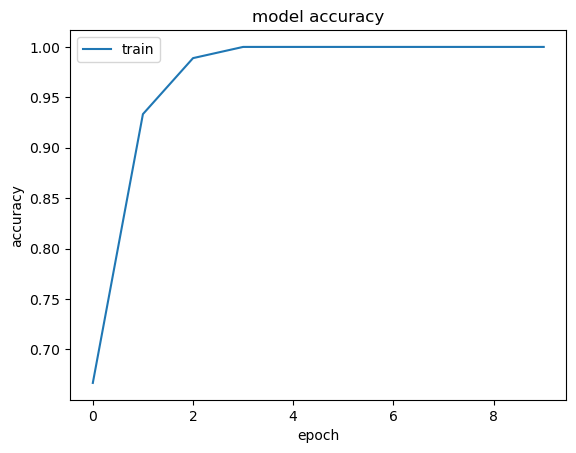

In [92]:
plt.plot(history.history['accuracy'][:10])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [528]:
history.history['accuracy']

[0.7833333611488342,
 0.9444444179534912,
 0.9944444298744202,
 0.9944444298744202,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
sub_DumbTo = sub_DumbTo.drop(columns=['Subject_ID'])

In [15]:
num_non_zero_nulls_in_cols = sub_DumbTo.isnull().sum().reset_index()
num_non_zero_nulls_in_cols.columns = ["Column", "Num_Nulls"]
num_non_zero_nulls_in_cols = num_non_zero_nulls_in_cols[num_non_zero_nulls_in_cols.Num_Nulls != 0]

In [16]:
num_non_zero_nulls_in_cols

,Column,Num_Nulls


In [17]:
# One participants had null values for the last four variables we drop that, so we reduce one from seq_length.shape[0]
# we dropped subject_id from related features so we have len(related_features) -1 in reshape dimmentions
x = sub_DumbTo.to_numpy()
x = x.reshape(int(num_of_subjects), -1, len(related_features) -1 )

In [18]:
print("x.shape: ", x.shape)

x.shape:  (43, 9743, 25)


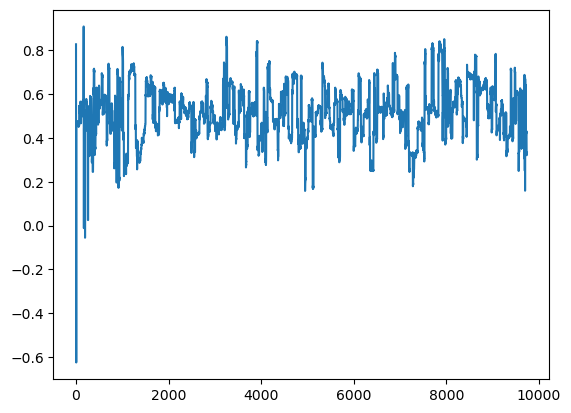

In [20]:
plt.plot(x[3][:, 2])
plt.show()

## Modeling

In [21]:
x_train = x[:37]
y_train = y[:37]
x_valid = x[37:]
y_valid = y[37:]

In [22]:
special_value = -9999.99
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)
x_valid = keras.preprocessing.sequence.pad_sequences(x_valid, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(37, 9743, 25)
(37,)
(6, 9743, 25)
(6,)


In [23]:
nan_count_df = pd.DataFrame(columns = related_features[1:])

In [24]:
nan_count_df

,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,RPCY,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Heart_Rate


In [25]:
for i in range(x.shape[0]):
    nan_count_df.loc[len(nan_count_df)] = sum(np.isnan(x[i]), 0)

In [26]:
df_nan_ratio = (nan_count_df[['FPOGX', 'FPOGY', 'BPOGX', 'BPOGY', 
       'LPCX', 'LPCY', 'Normed_LPD', 'Normed_LPS', 'RPCX', 'RPCY', 'Normed_RPD', 'Normed_RPS', 
       'LPUPILD', 'RPUPILD']]/cut_off) 

In [27]:
x.shape

(43, 9743, 25)

In [28]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(1))

model.compile(loss = keras.losses.MeanSquaredError(),
              optimizer = keras.optimizers.Adam(learning_rate=0.01))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 9743, 25)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                23040     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(x = x_train, y = y_train, 
                    validation_data = (x_valid, y_valid),
                    epochs = 20)

Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 57.1346 - val_loss: 24.9847
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 30.3517 - val_loss: 13.5678
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 17.0741 - val_loss: 5.7431
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 6.9009 - val_loss: 2.3670
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 1.4013 - val_loss: 4.3844
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 1.5780 - val_loss: 6.6259
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 2.3875 - val_loss: 6.7964
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 2.0205 - val_loss: 5.7932
Epoch 9/20
2/2 [==============================] - 4s 2s/step - loss: 1.6364 - val_loss: 5.0519
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 1.3849 - val_loss: 4.6298
Epoch 11/20
2/2 [===========================

In [ ]:
def divide_seq(seq, n):
    
    

In [33]:
sub_DumbTo.head()

,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,RPCY,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Heart_Rate
1,0.68073,0.42222,0.68802,0.39259,0.25017,0.41186,1.808046,0.0,0.65154,0.40483,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.53562,1.23894,-0.985122,80.0
2,0.68125,0.42685,0.68750,0.49259,0.25011,0.41384,-0.821955,0.0,0.65151,0.40529,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.53562,1.23894,-0.985122,80.0
3,0.68125,0.43241,0.68594,0.50556,0.25011,0.41384,-0.821955,1.0,0.65146,0.40563,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.53562,1.23894,-0.985122,80.0
4,0.87396,0.43611,2.58698,0.46574,0.24719,0.40959,-12.431953,0.0,0.60381,0.47703,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.53562,1.23894,-0.985122,80.0
5,0.87396,0.43611,2.58698,0.46574,0.06935,0.33554,-11.791954,0.0,0.57383,0.47479,...,-0.261916,-1.104235,-3.085957,-0.276813,2.562142,0.683569,-1.53562,1.23894,-0.985122,80.0


In [ ]:
y_df = pd.DataFrame(y)
y_df.columns = ['Cont']
y_df["Dis"] = 1
y_df.loc[y_df.Cont > 5, "Dis"] = 2
y_df.loc[y_df.Cont < 3, "Dis"] = 0

In [ ]:
y_df.head()

In [ ]:
y = np.array(y_df.Dis)
y_train = y[:37]
y_valid = y[37:]

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history = model.fit(x = x_train, y = y_train, 
                    validation_data = (x_valid, y_valid),
                    epochs = 10)

In [ ]:
y_score = model.predict(x_valid)
y_score

In [ ]:
y_valid

In [ ]:
feature_idx = 15

In [ ]:
plt.style.use('classic')
fig, ax = plt.subplots()

In [ ]:
plt.plot(x_valid[0][:,feature_idx])
plt.plot(x_valid[1][:,feature_idx])
plt.plot(x_valid[2][:,feature_idx])
plt.plot(x_valid[3][:,feature_idx])
plt.plot(x_valid[4][:,feature_idx])
plt.plot(x_valid[5][:,feature_idx])
plt.show()

In [ ]:
plt.plot(x_valid[2][:,feature_idx])
plt.plot(x_valid[4][:,feature_idx])
plt.plot(x_valid[5][:,feature_idx])
plt.show()

In [ ]:
y_dis_pred_valid

In [ ]:
y_dis_train = tf.keras.utils.to_categorical(y_dis_train, num_classes=3)
y_dis_valid = tf.keras.utils.to_categorical(y_dis_valid, num_classes=3)

In [ ]:
y_dis_valid

In [ ]:
n_classes = 3
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_dis_valid[:, i],
                                                        y_dis_pred_valid[:, i])
    average_precision[i] = average_precision_score(y_dis_valid[:, i], y_dis_pred_valid[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_dis_valid.ravel(),
     y_dis_pred_valid.ravel())
average_precision["micro"] = average_precision_score(y_dis_valid,  y_dis_pred_valid,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

## Sklearn Example for Percision Recall Curve
[link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [ ]:

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [ ]:
y_dis_pred_valid

In [ ]:
y_pred_naive = np.full(y_dis_valid.shape, 2)
accuracy_score(y_dis_valid, y_pred_naive)

In [ ]:
y_dis_valid

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history = model.fit(x = x_train, y = y_dis_train, 
                    validation_data = (x_valid, y_dis_valid),
                    epochs = 25)

In [ ]:
y_dis_valid

In [ ]:
y_dis_train